# Plant Seedlings Classification (PyTorch-Resnet18)

https://www.kaggle.com/competitions/plant-seedlings-classification

## Setup

In [1]:
import os
import glob
from pathlib import Path
import random
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torchinfo

In [2]:
IS_KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

COMP_NAME = 'plant-seedlings-classification'
if COMP_NAME is None:
    raise NameError('COMP_NAME has not been initialized')

DATA_PATH = Path('../input/' + COMP_NAME) if IS_KAGGLE else Path('./data')

RANDOM_SEED = 42
BATCH_SIZE = 32

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print('kaggle:', 'Y' if IS_KAGGLE else 'N')
print('torch version:', torch.__version__)
print('device:', DEVICE)
print(torch.cuda.device_count(), 'GPU(s) available')

kaggle: N
torch version: 2.0.1
device: cuda
2 GPU(s) available


In [4]:
# reproducibility

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Load Data

In [5]:
path = Path('./data')
if not DATA_PATH.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(COMP_NAME)
    zipfile.ZipFile(f'{COMP_NAME}.zip').extractall(DATA_PATH)

In [6]:
# values from ImageNet, recommended by PyTorch
transform_mean = [0.485, 0.456, 0.406]
transform_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=transform_mean, std=transform_std),
])

all_ds = datasets.ImageFolder(root=DATA_PATH/'train', transform=transform)

## Data Exploration

In [7]:
all_samples = len(all_ds)

print(all_samples, 'samples')
print(len(all_ds.classes), 'labels')

4750 samples
12 labels


In [8]:
label_counts = []

for d in glob.glob(os.path.join(DATA_PATH/'train', '*')):
    label = os.path.basename(d)
    count = len(glob.glob(os.path.join(d, '*')))
    label_counts.append({'label': label, 'count': count})

label_counts_df = pd.DataFrame(label_counts)
print(label_counts_df)

                        label  count
0                 Black-grass    263
1                    Charlock    390
2                    Cleavers    287
3            Common Chickweed    611
4                Common wheat    221
5                     Fat Hen    475
6            Loose Silky-bent    654
7                       Maize    221
8           Scentless Mayweed    516
9             Shepherds Purse    231
10  Small-flowered Cranesbill    496
11                 Sugar beet    385


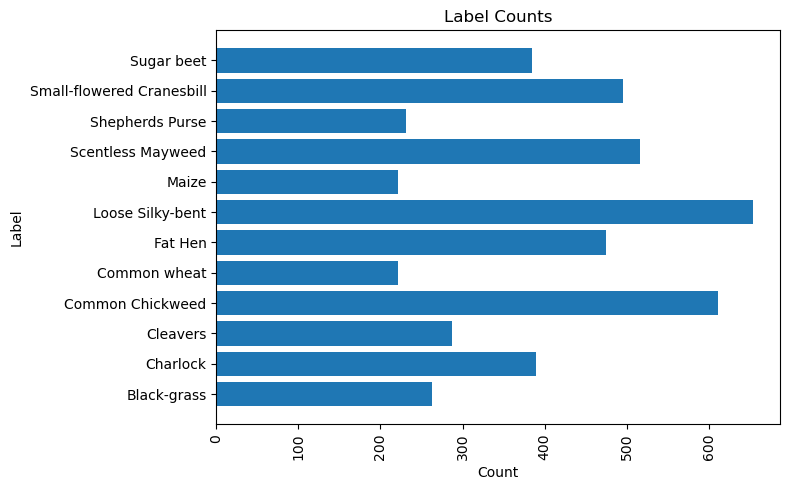

In [9]:
plt.figure(figsize=(8, 5))
plt.barh(label_counts_df['label'], label_counts_df['count'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Label Counts')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

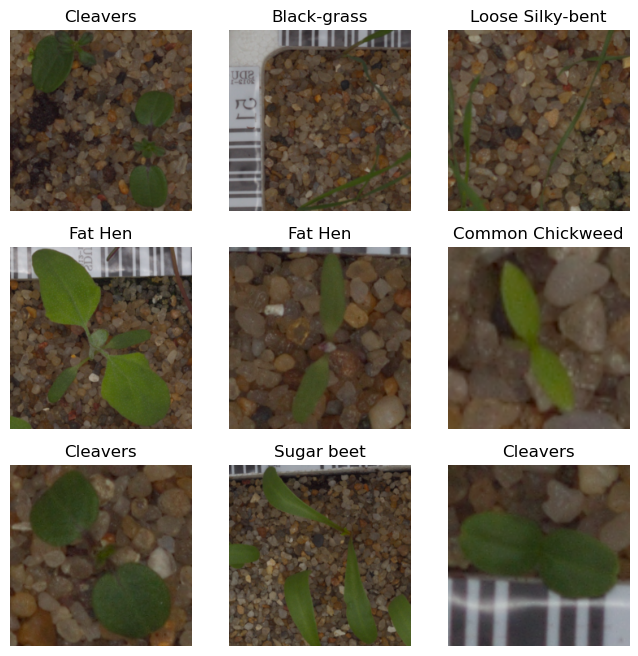

In [10]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3

labels = all_ds.classes

for i in range(1, cols * rows + 1):
    sample = all_ds[random.randint(0, len(all_ds)-1)]
    label = sample[1]
    
    img = sample[0].permute(1, 2, 0) # (3, 224, 224) -> (224, 224, 3)
    img = transform_std * np.array(img) + transform_mean # undo normalization
    
    figure.add_subplot(rows, cols, i)
    plt.title(labels[label])
    plt.axis('off')
    plt.imshow(img)

plt.show()

## Prepare Training/Validation Data

In [22]:
total_samples = len(all_ds)
train_size = int(total_samples * 0.8)
valid_size = total_samples - train_size

train_ds, valid_ds = torch.utils.data.random_split(all_ds, [train_size, valid_size])

print('train:', len(train_ds), 'samples')
print('valid:', len(valid_ds), 'samples')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

train: 3800 samples
valid: 950 samples


## Build Model

In [12]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

input_features = model.fc.in_features
model.fc = nn.Linear(input_features, len(all_ds.classes), device=DEVICE)
model = model.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.25)

print(model)
torchinfo.summary(model, (BATCH_SIZE, 3, 224, 224), col_names=('input_size', 'output_size', 'num_params', 'kernel_size'), verbose=0)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
ResNet                                   [32, 3, 224, 224]         [32, 12]                  --                        --
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 64, 112, 112]        9,408                     [7, 7]
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        128                       --
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --                        3
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 64, 56, 56]          --                        --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          [32, 64, 56, 56]          --                        --
│    │    └

## Train Model

In [13]:
def train_step(dataloader, model, loss_fn, optimizer, print_every=100):
    losses = []
    model.train()

    for batch, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        # print results
        if batch % print_every == 0:
            loss, current = loss.item(), (batch + 1) * len(inputs)
            print(f'  Training: Loss = {loss:>7f} [{current:>5d}/{len(dataloader.dataset):>5d}]')
    return losses

In [14]:
def valid_step(dataloader, model, loss_fn):
    model.eval()
    loss, correct = 0, 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)

            loss += loss_fn(outputs, targets).item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets.data).sum().item()

    loss /= BATCH_SIZE
    correct /= len(dataloader.dataset)
    print(f'  Validation: Accuracy={(100 * correct):>0.1f}%, Average_Loss={loss:>8f}\n')

In [15]:
epochs = 10
losses = []

for epoch in range(epochs):
    print(f'Epoch [{epoch+1:>2d}/{epochs}]\n-------------------------------')
    epoch_losses = train_step(train_loader, model, loss_fn, optimizer, print_every=25)
    valid_step(valid_loader, model, loss_fn)
    losses.extend(epoch_losses)

Epoch [ 1/10]
-------------------------------
  Training: Loss = 2.616395 [   32/ 3750]
  Training: Loss = 1.892667 [  832/ 3750]
  Training: Loss = 1.406837 [ 1632/ 3750]
  Training: Loss = 0.883020 [ 2432/ 3750]
  Training: Loss = 0.800289 [ 3232/ 3750]
  Validation: Accuracy=83.2%, Average_Loss=0.565216

Epoch [ 2/10]
-------------------------------
  Training: Loss = 0.709209 [   32/ 3750]
  Training: Loss = 0.386063 [  832/ 3750]
  Training: Loss = 0.390533 [ 1632/ 3750]
  Training: Loss = 0.384306 [ 2432/ 3750]
  Training: Loss = 0.417368 [ 3232/ 3750]
  Validation: Accuracy=90.3%, Average_Loss=0.293965

Epoch [ 3/10]
-------------------------------
  Training: Loss = 0.161788 [   32/ 3750]
  Training: Loss = 0.332060 [  832/ 3750]
  Training: Loss = 0.305764 [ 1632/ 3750]
  Training: Loss = 0.244053 [ 2432/ 3750]
  Training: Loss = 0.196574 [ 3232/ 3750]
  Validation: Accuracy=92.5%, Average_Loss=0.234347

Epoch [ 4/10]
-------------------------------
  Training: Loss = 0.169456

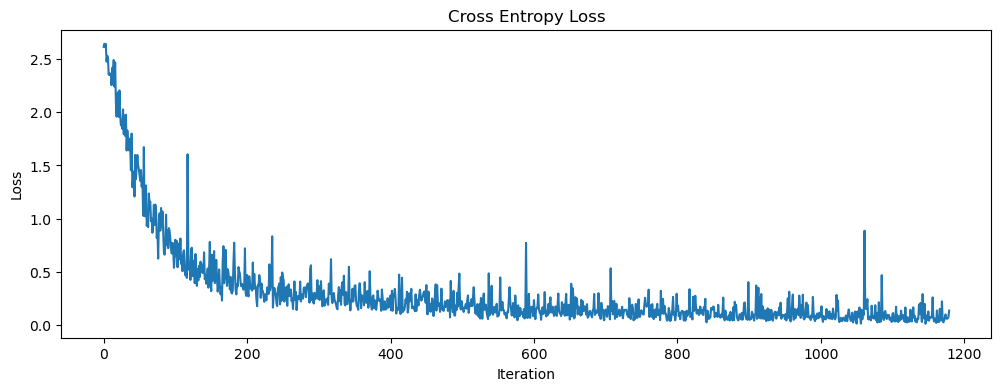

In [16]:
plt.figure(figsize=(12, 4))

plt.plot(losses)
plt.title('Cross Entropy Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.show()

## Submission

In [17]:
class TestDataset(Dataset):
    def __init__(self, test_path, transform=None):
        self.test_path = test_path
        self.transform = transform

    def __len__(self):
        return len(glob.glob(f'{self.test_path}/*.png'))

    def __getitem__(self, index):
        img_path = os.path.join(self.test_path, os.listdir(self.test_path)[index])
        img = Image.open(img_path)

        if self.transform is not None:
            img = self.transform(img)
        return img

In [20]:
test_path = DATA_PATH/'test'

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(transform_mean, transform_std)
])

test_ds = TestDataset(test_path, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print('Test:', len(test_ds), 'samples')

Test: 794 samples


In [21]:
labels = []

model.eval()

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        labels.extend(preds.cpu().numpy().tolist())

species = [all_ds.classes[label] for label in labels]

submission = pd.DataFrame({'file': os.listdir(test_path), 'species': species})
submission.to_csv('submission.csv', index=False)